<a href="https://colab.research.google.com/github/dominiquebuford/CV_individualproject/blob/main/Chapter08/Training_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('darknet'):
    !git clone https://github.com/AlexeyAB/darknet
    %cd darknet
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    # !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    !make
    !pip install -q torch_snippets

    !wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

nvcc -gencode arch=compute_50,code=[sm_50,compute_50] -gencode arch=compute_52,code=[sm_52,compute_52] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_70,code=[sm_70,compute_70] -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF --compiler-options "-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF" -c ./src/activation_kernels.cu -o obj/activation_kernels.o
nvcc -gencode arch=compute_50,code=[sm_50,compute_50] -gencode arch=compute_52,code=[sm_52,compute_52] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_70,code=[sm_70,compute_70] -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF --compiler-options "-Wall -Wfat

In [2]:
!wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
!tar -xf open-images-bus-trucks.tar.xz
!rm open-images-bus-trucks.tar.xz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#figure out how to put my zip file somewhere that i can access here

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

In [4]:
%%writefile data/obj.names
drink
laptop
utensil

Writing data/obj.names


In [5]:
%%writefile data/obj.data
classes = 3
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [6]:
!mkdir -p data/obj
!cp -r ../drive/MyDrive/CV_individualproject/images/* data/obj/
!cp -r ../drive/MyDrive/CV_individualproject/{train,val}.txt data/
!cp -r ../drive/MyDrive/CV_individualproject/labels/*.txt data/obj/

In [7]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-drink-laptop-utensil.cfg
# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-drink-laptop-utensil.cfg
# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-drink-laptop-utensil.cfg
# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-drink-laptop-utensil.cfg
# number of classes is 3 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=3/g' cfg/yolov4-drink-laptop-utensil.cfg
# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=24/g' cfg/yolov4-drink-laptop-utensil.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-drink-laptop-utensil.cfg

In [8]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-drink-laptop-utensil.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

In [10]:
from torch_snippets import Glob, stem, show, read

!./darknet detector test data/obj.data cfg/yolov4-drink-laptop-utensil.cfg yolov4.weights data/obj/05993C52-D3D7-4847-8CB3-8AC92F9586EF_1_105_c.jpeg
!mv predictions.jpg 05993C52-D3D7-4847-8CB3-8AC92F9586EF_1_105_c_pred.jpg



 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	    

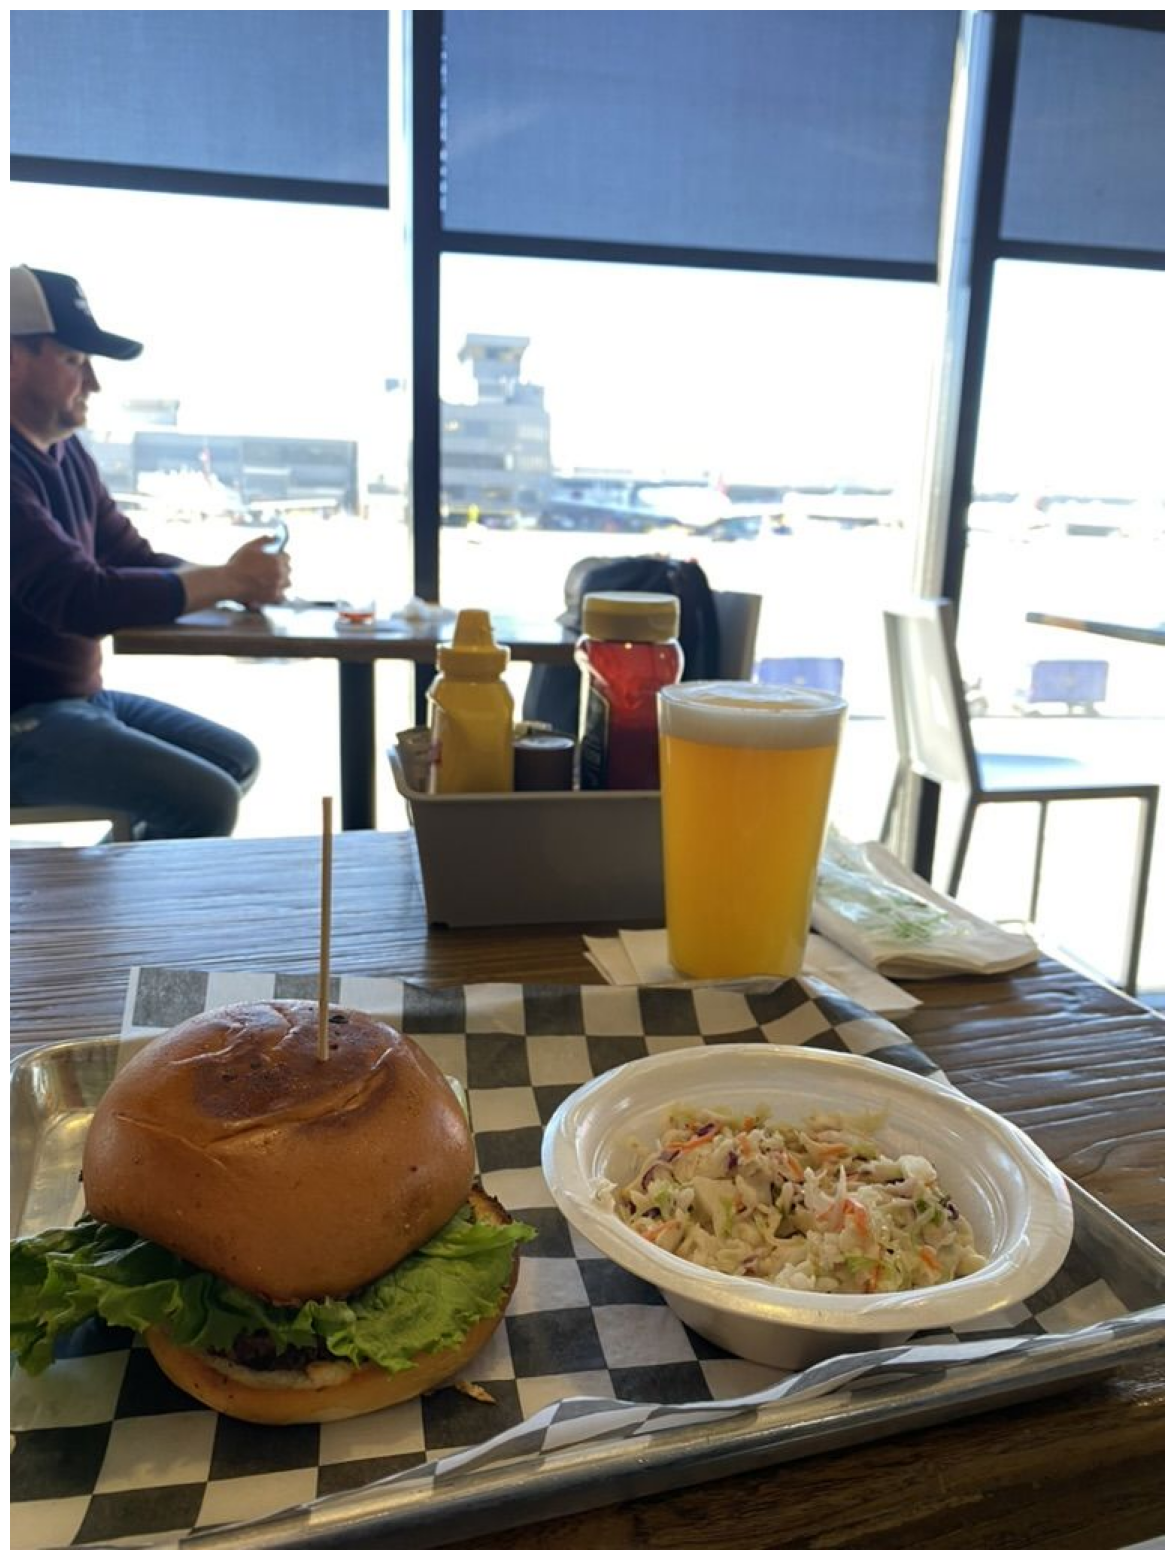

In [12]:
show(read('05993C52-D3D7-4847-8CB3-8AC92F9586EF_1_105_c_pred.jpg', 1), sz=20)

2020-11-09 03:24:37.260 | INFO     | torch_snippets.loader:Glob:181 - 3 files found at pred_*.png


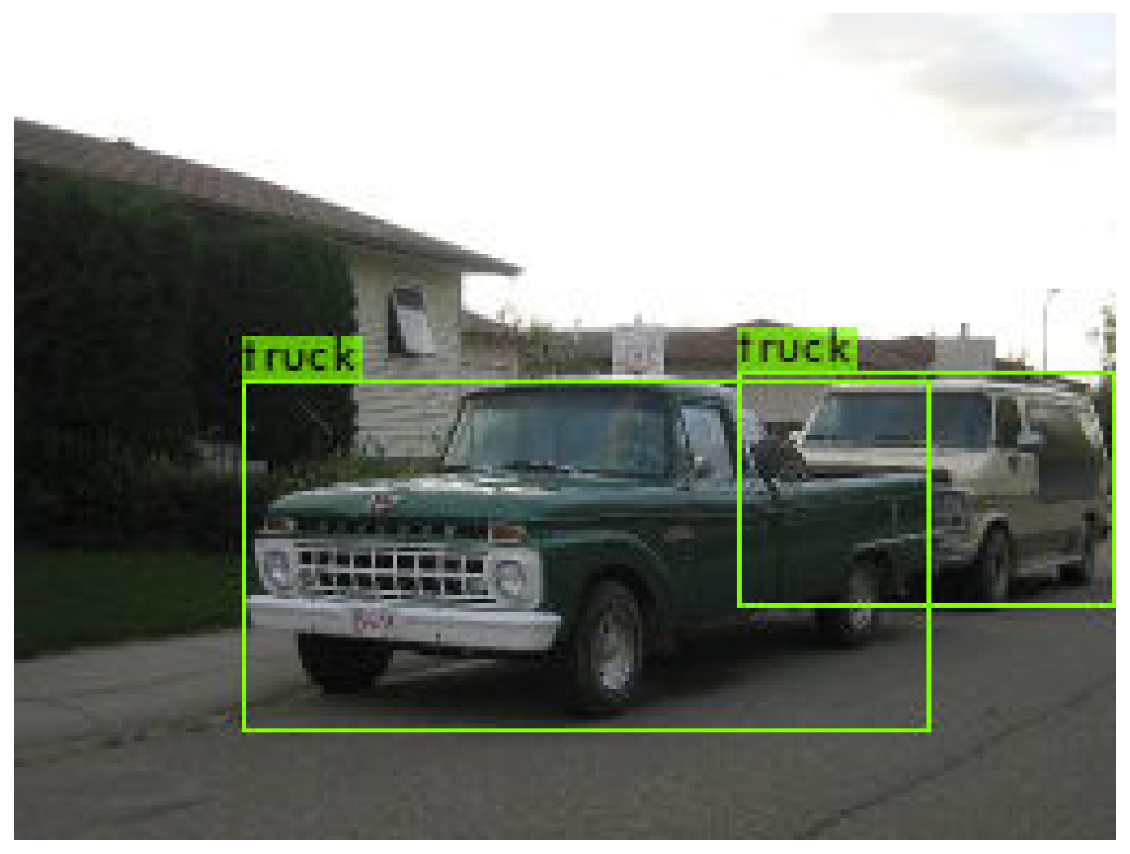

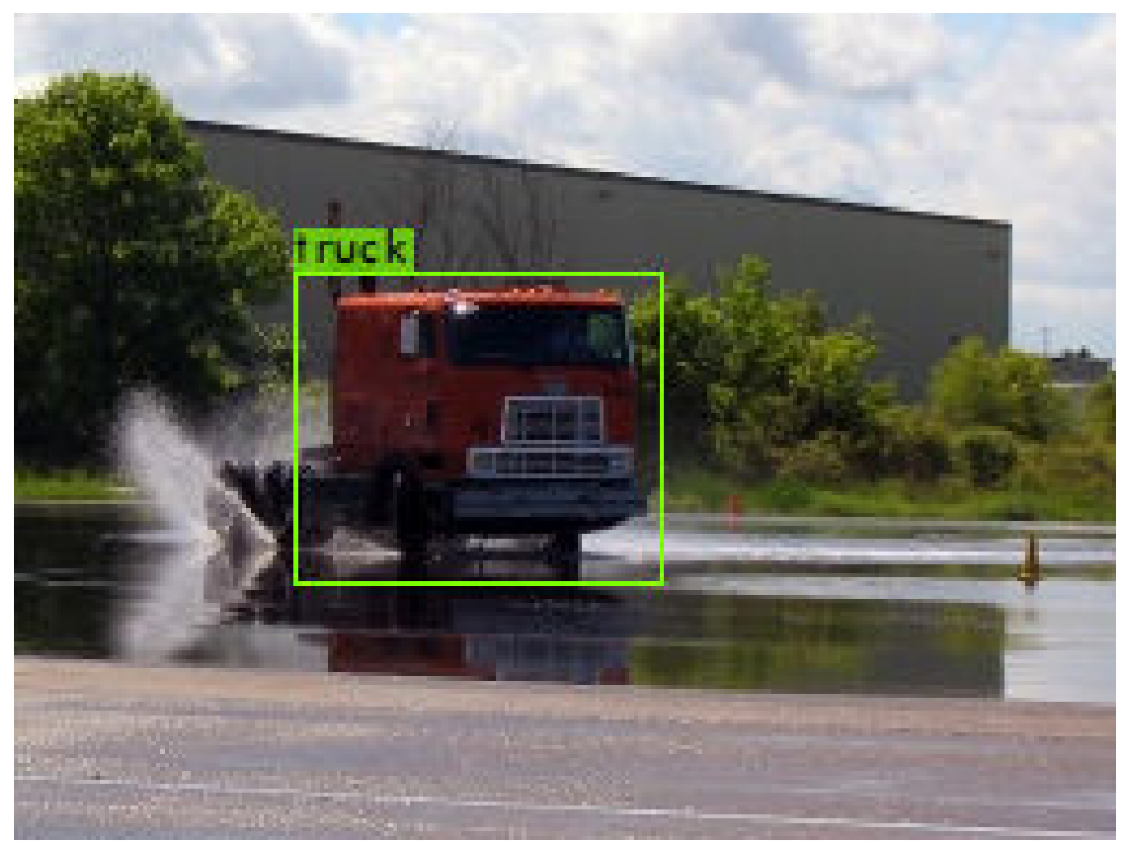

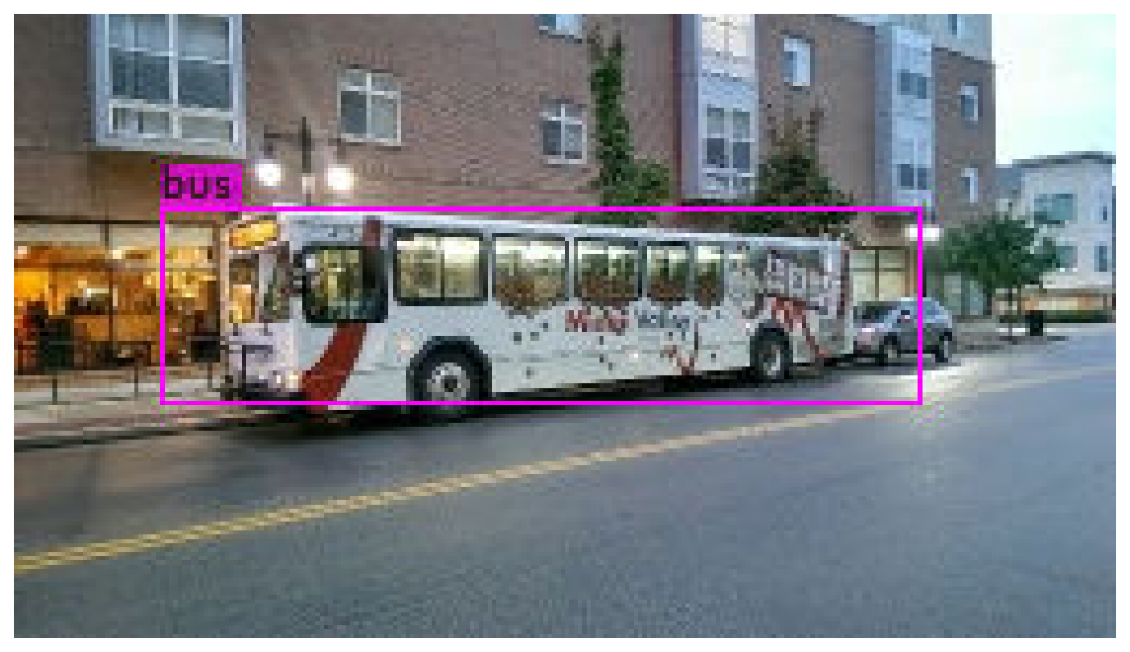

In [ ]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = Glob('images-of-trucks-and-busses')
for f in image_paths:
    !./darknet detector test data/obj.data cfg/yolov4-drink-laptop-utensil.cfg\
    backup/yolov4-drink-laptop-utensil.weights {f}
    !mv predictions.jpg {stem(f)}_pred.jpg

for i in Glob('*_pred.jpg', silent=True):
    show(read(i, 1), sz=20)